In [3]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from math import log2
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pylab as plt

In [4]:
# from utils.setup import load_model

# from torchsummary import summary

# model = load_model('netG', 'configs/config_StyleGan16x16.yaml')

# summary(model, [512], depth=2);

In [5]:
# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters())
# count_parameters(model)

In [6]:
DATSET = 'data'

START_TRAIN_IMG_SIZE = 4
DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu'
LR = 1e-3
BATCH_SIZES = [256,256,128,64,32,16,8,4,4]# since when the image size increases, the computational cost also increases. So, we should decrease the bacth size
CHANNELS_IMG = 3
Z_DIM = 512
W_DIM = 512
IN_CHANNELS = 512
LAMBDA_GP = 10 ##used for caclulating discriminator loss
PROGRESSIVE_EPOCHS = [2] * len(BATCH_SIZES)#we can ensure that each stage of the model is adequately trained before moving on to the next stage.

In [7]:
# Noice apping network
# AdaIN
# Progressice growing
factors = [1,1,1,1/2,1/4,1/8,1/16,1/32, 1/64, 1/128, 1/128] # used to reduce 512 channel

In [34]:
def get_loader(image_size): ##image_size is the output size of each layer
    trainsform = transforms.Compose(
        [
         transforms.CenterCrop((512, 512)), #crop the image from center
         transforms.Resize((image_size, image_size)),
         transforms.ToTensor(), # c*h*w and value betwenn 0,1 (like a list of list)
         transforms.RandomHorizontalFlip(p=0.5),
         transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], #mean
            [0.5 for _ in range(CHANNELS_IMG)], #sigma
         )
        ]
    )
    batch_size = BATCH_SIZES[int(log2(image_size/4))] ## inner part determines the number of resolution levels in the generator and discriminator
    dataset=datasets.Flowers102(root=DATSET, split= 'train', transform=trainsform, download = True)
    
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True
    )
    return loader, dataset

In [9]:
with open("flower_love.txt", "r") as f:
    lables2names = list(map(lambda x:x.strip(), f.readlines()))

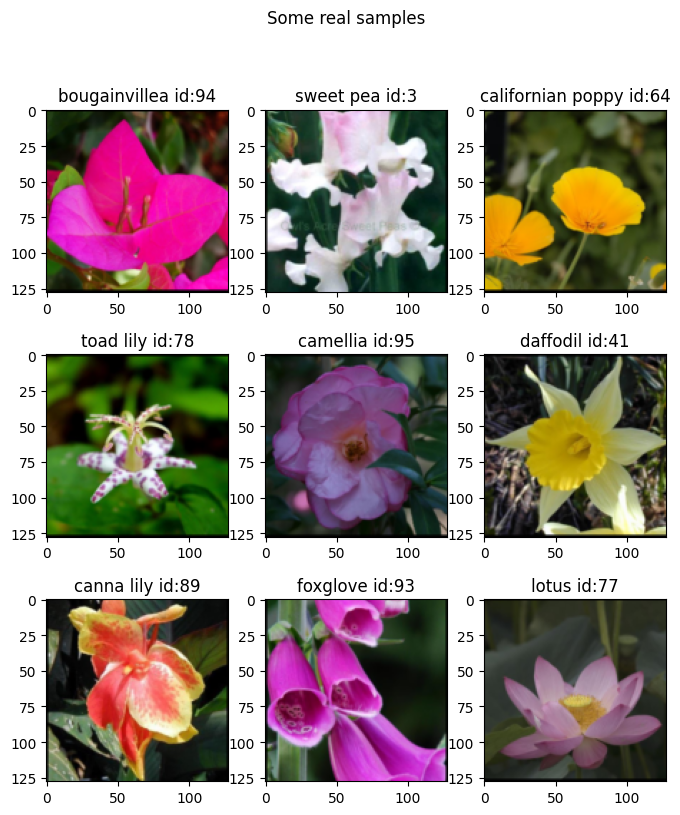

In [38]:
def check_loader(): # a simple visual check to make sure that the data loader is working correctly
    loader,_ = get_loader(128)
    flowers,labels  = next(iter(loader)) #retrieves the next batch of data from a PyTorch data loader
    _,ax     = plt.subplots(3,3,figsize=(8,9))
    plt.suptitle('Some real samples')
    ind = 0
    for k in range(3):
        for kk in range(3):
            ax[k][kk].imshow((flowers[ind].permute(1,2,0)+1)/2)
            id = labels[ind].item()
            ax[k][kk].set_title(f"{lables2names[id]} id:{id}")

            ind +=1
check_loader() 

In [11]:
loader,_ = get_loader(128)

In [12]:
print(len(loader.dataset))

dataset=datasets.Flowers102(root=DATSET, split= 'test', download = True)
print(len(dataset))

1020
6149


In [13]:
class WSLinear(nn.Module): #it is just one layer to scale weights
    def __init__(
        self, in_features, out_features
    ):
        super().__init__()                                                       
        
        self.linear = nn.Linear(in_features, out_features)# linear transformaton on data y=X*W(^T)+b
        self.scale  = (2/in_features) ** 0.5 ## scaling the weights of each layer according to the input size.
        self.bias   = self.linear.bias
        self.linear.bias = None #By setting the bias to None, the bias of the linear layer is removed and will not be used during the forward pass

        nn.init.normal_(self.linear.weight)#values of W are drawn from a normal distribution with mean 0 and standard deviation 1.
        nn.init.zeros_(self.bias)

    def forward(self,x):
        return self.linear(x * self.scale) + self.bias ##weight scaling technique involves removing the bias from the linear layer so add bias seperately
    
    # The output of this linear layer will be a set of scaling factors for each channel of the input tensor

In [14]:
class PixenNorm(nn.Module):#normalize features to be in the same range improving stability
    def __init__(self):
        super(PixenNorm, self).__init__()
        self.epsilon = 1e-8 ##to prevent division by zero
    def forward(self,x ):
        return x / torch.sqrt(torch.mean(x**2, dim=1, keepdim=True)+  self.epsilon)## Mean across rows since dim=1

In [15]:
class MappingNetwork(nn.Module):
    def __init__(self, z_dim, w_dim):
        super().__init__()
        self.mapping = nn.Sequential(
            PixenNorm(),                                
            WSLinear(z_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
        )
    
    def forward(self,x):
        return self.mapping(x)

In [16]:
class AdaIN(nn.Module):
    def __init__(self, channels, w_dim):
        super().__init__()
        self.instance_norm = nn.InstanceNorm2d(channels)
        self.style_scale   = WSLinear(w_dim, channels) #as ys to the size of channels
        self.style_bias    = WSLinear(w_dim, channels) #as yb to the size of channels

    def forward(self,x,w): #w is a learnable style vector
        x = self.instance_norm(x) 
        style_scale = self.style_scale(w).unsqueeze(2).unsqueeze(3)#add dimention to w to be in the size of x
        style_bias  = self.style_bias(w).unsqueeze(2).unsqueeze(3)
        return style_scale * x + style_bias

In [17]:
class injectNoise(nn.Module):#introduce stochasticity and prevent overfitting during training
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1,channels,1,1))

    def forward(self, x): #size(numofbatch,channel,h,w)
        noise = torch.randn((x.shape[0], 1, x.shape[2], x.shape[3]), device = x.device)
        
        B=self.weight *noise  
        return x + B                                                                                          

In [18]:
class WSConv2d(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (2 / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)

In [19]:
class GenBlock(nn.Module):
    def __init__(self, in_channel, out_channel, w_dim):
        super(GenBlock, self).__init__()
        self.conv1 = WSConv2d(in_channel, out_channel)
        self.conv2 = WSConv2d(out_channel, out_channel)
        self.leaky = nn.LeakyReLU(0.2, inplace=True)
        self.inject_noise1 = injectNoise(out_channel)
        self.inject_noise2 = injectNoise(out_channel)
        self.adain1 = AdaIN(out_channel, w_dim)
        self.adain2 = AdaIN(out_channel, w_dim)
    def forward(self, x,w):
        x = self.adain1(self.leaky(self.inject_noise1(self.conv1(x))), w)
        x = self.adain2(self.leaky(self.inject_noise2(self.conv2(x))), w)
        return x

In [20]:
class Generator(nn.Module):
    def __init__(self, z_dim, w_dim, in_channels, img_channels=3):
        super().__init__()
        self.starting_cte = nn.Parameter(torch.ones(1, in_channels, 4,4))
        # self.map = MappingNetwork(z_dim, w_dim)
        self.map = nn.Identity()
        self.initial_adain1 = AdaIN(in_channels, w_dim)
        self.initial_adain2 = AdaIN(in_channels, w_dim)
        self.initial_noise1 = injectNoise(in_channels)
        self.initial_noise2 = injectNoise(in_channels)
        self.initial_conv   = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.leaky          = nn.LeakyReLU(0.2, inplace=True)

        self.initial_rgb    = WSConv2d(
            in_channels, img_channels, kernel_size = 1, stride=1, padding=0
        )
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]), #used to keep iterable modules  
            nn.ModuleList([self.initial_rgb])
        )

        for i in range(len(factors)-1):
            conv_in_c  = int(in_channels * factors[i])                                             
            conv_out_c = int(in_channels * factors[i+1])
            self.prog_blocks.append(GenBlock(conv_in_c, conv_out_c, w_dim))
            self.rgb_layers.append(WSConv2d(conv_out_c, img_channels, kernel_size = 1, stride=1, padding=0))# in this part the chennel of output will be set to 3. it gets 512/16 as input ok
        
    def fade_in(self, alpha, upscaled, generated):                                                     #######important####### I think it needs to upsample upscaled images by 2 to be on the same size with output???
        return torch.tanh(alpha * generated + (1-alpha ) * upscaled) #tanh is  an activation function

    def forward(self, noise, alpha, steps):
        w = self.map(noise)
        x = self.initial_adain1(self.initial_noise1(self.starting_cte),w)                                 #### to remove mapping network we coud feed noise directrly instead of w, right???
        x = self.initial_conv(x)
        out = self.initial_adain2(self.leaky(self.initial_noise2(x)), w)

        if steps == 0:
            return self.initial_rgb(x)
        
        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode = 'bilinear')
            out      = self.prog_blocks[step](upscaled,w)

        final_upscaled = self.rgb_layers[steps-1](upscaled)
        final_out      = self.rgb_layers[steps](out)

        return self.fade_in(alpha, final_upscaled, final_out)#applied at the end to blend the outputs of the previous and current step, produce smooth transition between resolutions

In [21]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.leaky(self.conv2(x))
        return x

In [22]:
class Discriminator(nn.Module):                                                                                                                 ##it gets fack and the previous ouput, fade,calculate std, set of liniear layer on it...
    def __init__(self, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(factors) - 1, 0, -1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        # perhaps confusing name "initial_rgb" this is just the RGB layer for 4x4 input size
        # did this to "mirror" the generator initial_rgb
        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool                                                                                                #does it downsample real images?

        # this is the block for 4x4 input size
        self.final_block = nn.Sequential(                                                                                                     #???
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):#calculates the standard deviation across the batch for each channel
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1) 

    def forward(self, x, alpha, steps):
        # where we should start in the list of prog_blocks, maybe a bit confusing but
        # the last is for the 4x4. So example let's say steps=1, then we should start
        # at the second to last because input_size will be 8x8. If steps==0 we just
        # use the final block
        cur_step = len(self.prog_blocks) - steps

        # convert from rgb as initial step, this will depend on
        # the image size (each will have it's on rgb layer)
        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  # i.e, image is 4x4
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        # because prog_blocks might change the channels, for down scale we use rgb_layer
        # from previous/smaller size which in our case correlates to +1 in the indexing
        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))

        # the fade_in is done first between the downscaled and the input
        # this is opposite from the generator
        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

In [23]:
def generate_examples(gen, steps, n=100):

    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.randn(1, Z_DIM).to(DEVICE)
            img = gen(noise, alpha, steps)
            if not os.path.exists(f'saved_examples/step{steps}'):
                os.makedirs(f'saved_examples/step{steps}')
            save_image(img*0.5+0.5, f"saved_examples/step{steps}/img_{i}.png")
    gen.train()
    
    #in train mode it updates parameters while in eval it does not compute gradient and it is used to evaluate performance

In [24]:
def gradient_penalty(critic, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)
 
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(#Computes and returns the sum of gradients of outputs with respect to the inputs(dl/di?)
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)#||a||
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [25]:
def train_fn(
    critic,
    gen,
    loader,
    dataset,
    step,
    alpha,
    opt_critic,
    opt_gen,
    loop,
):
    for real, _ in loader:
        real = real.to(DEVICE)
        cur_batch_size = real.shape[0]
        noise = torch.randn(cur_batch_size, Z_DIM).to(DEVICE)
        fake  = gen(noise, alpha, step)
        critic_real = critic(real, alpha, step)
        critic_fake = critic(fake.detach(), alpha, step)
        gp = gradient_penalty(critic, real, fake, alpha, step, DEVICE)
        loss_critic = (#Compute the loss for the critic model using the Wasserstein distance 
            -(torch.mean(critic_real) - torch.mean(critic_fake))
            + LAMBDA_GP * gp
            + (0.001) * torch.mean(critic_real ** 2)
        )

        critic.zero_grad()
        loss_critic.backward()
        opt_critic.step()#Update the critic model parameters

        gen_fake = critic(fake, alpha, step)
        loss_gen = -torch.mean(gen_fake)#Compute the loss for the generator model using the negative critic loss 

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        alpha += cur_batch_size / (#Adjust the alpha value based on the number of processed images and the total number of images in the datasetAdjust the alpha value based on the number of processed images and the total number of images in the dataset
            PROGRESSIVE_EPOCHS[step] * 0.5 * len(dataset)
        )
        alpha = min(alpha,1)


        loop.set_postfix(
            gp = gp.item(),
            loss_critic = loss_critic.item()
        )
    return alpha

In [26]:
gen = Generator(
    Z_DIM, W_DIM, IN_CHANNELS, CHANNELS_IMG
).to(DEVICE)
critic = Discriminator(IN_CHANNELS, CHANNELS_IMG).to(DEVICE)

#Implements Adam algorithm.

opt_gen = optim.Adam([{'params': [param for name, param in gen.named_parameters() if 'map' not in name]},
                     {'params': gen.map.parameters(), 'lr': 1e-5}], lr=LR, betas =(0.5, 0.99))
opt_critic = optim.Adam(
    critic.parameters(), lr= LR, betas =(0.5, 0.99)
)

In [27]:

gen.train()#training mode
critic.train()
step = int(log2(START_TRAIN_IMG_SIZE / 4))
for num_epochs in PROGRESSIVE_EPOCHS[step:]:
    alpha = 1e-7
    loader, dataset = get_loader(4*2**step)
    print('Curent image size: '+str(4*2**step), "step", step)
    loop = tqdm(range(num_epochs), leave=True, )
    loop.set_description(f'Epochs')
    for epoch in loop:
        alpha = train_fn(
            critic, gen, loader, dataset, step, alpha, opt_critic, opt_gen, loop
        )
    generate_examples(gen, step)
    step +=1


Curent image size: 4 step 0


Epochs: 100%|██████████| 2/2 [00:13<00:00,  6.94s/it, gp=0.449, loss_critic=-23.3] 


Curent image size: 8 step 1


Epochs: 100%|██████████| 2/2 [00:13<00:00,  6.96s/it, gp=0.186, loss_critic=-7.18]  


Curent image size: 16 step 2


Epochs: 100%|██████████| 2/2 [00:25<00:00, 12.68s/it, gp=0.563, loss_critic=-19.5]


Curent image size: 32 step 3


Epochs: 100%|██████████| 2/2 [01:05<00:00, 32.81s/it, gp=1.54, loss_critic=-50.2] 


Curent image size: 64 step 4


Epochs: 100%|██████████| 2/2 [02:02<00:00, 61.15s/it, gp=6.47, loss_critic=-157] 


Curent image size: 128 step 5


Epochs: 100%|██████████| 2/2 [03:57<00:00, 118.75s/it, gp=19.3, loss_critic=-356]


Curent image size: 256 step 6


Epochs: 100%|██████████| 2/2 [08:41<00:00, 260.93s/it, gp=58.3, loss_critic=-1.18e+3]


Curent image size: 512 step 7


Epochs: 100%|██████████| 2/2 [17:44<00:00, 532.14s/it, gp=90.7, loss_critic=-2.99e+3]


Curent image size: 1024 step 8


Epochs:   0%|          | 0/2 [00:04<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 1; 12.00 GiB total capacity; 10.97 GiB already allocated; 0 bytes free; 11.17 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [28]:
torch.save(gen.state_dict(), 'generator.ptk')

In [29]:
gen.load_state_dict(torch.load('generator.ptk'))

<All keys matched successfully>

In [30]:
generate_examples(gen, 8, 1000)

KeyboardInterrupt: 